**Atenção: Devido a natureza dos dados, para correto funcionamento, este notebook precisa ser executado em ambiente com memória RAM maior ou igual a 25 Gb.**

#**Ciência e Visualização de Dados**
##**Projeto Final - Entrega 03**
###Alunos: 
###Gleyson Roberto do Nascimento. RA: 043801. Elétrica.
###Negli René Gallardo Alvarado. RA: 234066. Saúde.
###Rafael Vinícius da Silveira. RA: 137382. Física.
###Sérgio Sevileanu. RA: 941095. Elétrica.



##Neste notebook do Google Colaboratory será realzada a aprendizagem de máquina para os dados do Estado da Bahia durante os anos de 2008 a 2018 segundo o banco de dados [SIHSUS](https://bigdata-metadados.icict.fiocruz.br/dataset/sistema-de-informacoes-hospitalares-do-sus-sihsus/resource/ae85ac54-6734-43b8-a820-6129a854e1ff).

##Desta forma, algumas definições iniciais e um disclaimer se fazem necessários para este projeto:

##Será definido como **diagnóstico equivocado (categoria 0 da variável v258)** aquele em que houve mais de um diagnóstico de CID10, contudo, eles fazem parte do mesmo grupo, de forma que é plausível o equívoco dada a semelhança de sintomas entre os CID10;
##Será definido como **falha de diagnóstico (categoria 1 da variável v258)** aquele em que houve mais de um diagnóstico de CID10, contudo, eles fazem parte de grupos distintos, de forma que embora possam existir sintomas semelhantes entre os CID10, caberia ao profissional uma análise mais aprofundada antes do diagnóstico.
##O **diagnóstico correto** (aquele em que houve apenas um diagnóstico de CID10, sem alterações durante o período até a alta) foi suprimido da análise devido ao fato de que evisiesava  resultados dado o altíssimo percentual de ocorrência; 
##**Disclaimer**: Considerando a natureza do banco de dados do SIHSUS, isto é, um Big Data em que inúmeros funcionários do Sistema Único de Saúde possuem acesso e inserem os dados de forma manual em realdades e condições bastante distintas, existe a séria possibildade de erro sistemático, desta forma, a acurácia deste trabalho deve ser considerada com ressalvas.

#Instalando o RAPIDS no Google Colab

##Verificando se há GPU disponível

In [ ]:
!nvidia-smi

Wed Jun 23 18:24:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Setup:
Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. BlazingSQL
  1. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.


In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 272 (delta 56), reused 38 (delta 19), pack-reused 171
Receiving objects: 100% (272/272), 79.66 KiB | 7.96 MiB/s, done.
Resolving deltas: 100% (118/118), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla P100-PCIE-16GB!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:11 https://developer.download.nvidia.com/co

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable

Installing RAPIDS Stable 21.06
Starting the RAPIDS+BlazingSQL install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids-blazing=21.06


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.1      |       h9c3ff4c_0        1015 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.2.0                |   py37h89c1867_0         138 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0      

#Instalando as Bibliotecas Necessárias

In [ ]:
%matplotlib inline
%load_ext google.colab.data_table
import matplotlib.pyplot as plt
import numpy as np
import gc
import pandas as pd
import pickle
import dask
import dask_cudf
import cudf
from datetime import datetime
from dask import dataframe as dd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
pd.set_option('display.max_columns', None)
pd.options.display.precision = 2
pd.options.display.max_rows = 50
import seaborn as sns
import missingno as msno
import matplotlib as mpl
from matplotlib import rcParams
from numba import jit, njit
mpl.rc('figure', max_open_warning = 0)
from sklearn import preprocessing

#Criando um Client para o Dask

In [ ]:
from dask.distributed import Client,wait
client = Client()
#client = Client(n_workers=2, threads_per_worker=4)
client.cluster

/usr/local/lib/python3.7/site-packages/distributed/client.py:1148: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.19.5 | 1.19.5    | 1.21.0  |
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


#Fazendo autenticação no Google, importando os arquivos através do Google Drive e criando Dask dataframes com limpeza de RAM (garbage collect).

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
ids = ['1Oyd1VdQo3fHJD5LGXNgi5kZBS812MiKN','183SF0fxXbTVXYfko-BOyuwAB2BmZQAmK']
estados = ['BR','BRPRO']
arquivo = ['brasil.pkl','brasilprocessed.pkl']

In [ ]:
dflist=[]
for i in range (len(ids)):
  fileDownloaded = drive.CreateFile({'id':ids[i]})
  fileDownloaded.GetContentFile(arquivo[i])
  globals()[estados[i]] = dd.from_pandas(pd.read_pickle(arquivo[i]),npartitions=245)
  n=gc.collect()
  globals()[estados[i]] = (globals()[estados[i]]).reset_index(drop=True)
  n=gc.collect()
  dflist.append(eval(estados[i]))
  n=gc.collect()

In [ ]:
dflist[0].head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v19,v20,v21,v22,v23,v27,v28,v29,v30,v31,v32,v33,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v54,v55,v56,v57,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v72,v73,v76,v77,v78,v79,v80,v82,v83,v85,v87,v88,v89,v90,v91,v92,v93,v94,v96,v97,v98,v100,v101,v104,v105,v106,v107,v108,v109,v112,v113,v114,v115,v116,v117,v118,v121,v122,v123,v124,v125,v126,v127,v128,v137,v138,v139,v141,v143,v145,v147,v149,v151,v153,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174,v175,v176,v177,v178,v179,v180,v181,v182,v183,v184,v185,v186,v187,v188,v189,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v215,v216,v218,v219,v220,v221,v222,v223,v224,v225,v226,v227,v228,v229,v230,v231,v232,v234,v235,v237,v238,v239,v241,v242,v243,v244,v245,v246,v247,v248,v249,v250,v261,v251,v252,v260,v262,v253,v254,v255,v256,v257,v258,v259
0,120000,2008,12,2,5.29e+11,1208100502730,AIH normal,1208100502730,1,Normal,69900100,120040,12,19791012,3,Feminino,0,0,0,0,Não utilizou UTI,0,0,5,411010026,411010026,700.79,447.15,1147.94,0.0,496.94,20081206,20081211,O324,O630,17,Alta da mãe/puérpera e do recém-nascido,61,NaN,NaN,2,Estadual plena,1,Sim,120040,12,4,Anos,29,5,5,0,Sem óbito,10,2,2,2,2,0,Sem filhos/Não inform,0,NaN,0,0,1,Sim,1208103541,0,Seqüencial zerado,0,0,0,NaN,1,21706700172,2002078,5.29e+11,NaN,NaN,2,Média complexidade,6,Média e Alta Complexidade (MAC),0,Sem regra contratual,3,Parda,NaN,3046,HE12000001N200812.DTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153.0,9222.58,120040,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153,9222.58,120040,AC,12,ACRE,AC,ACRE,Região Norte,Região Norte,Acre,AC,Acre,AC,Rio Branco,Rio Branco,NaN,NaN,Baixo Acre e Purus,Baixo Acre e Purus,Rio Branco,Rio Branco,Vale do Acre,Vale do Acre,Rio Branco,Acre,Acre,Região não definida - AC,Região não definida - AC,NaN,Brasil,Não Informado,Obstétricos,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,29,15-49a,25-34a,25-29a,Capítulo XV - Gravidez; parto e puerpério,Assistência prestada à mãe por motivos ligados...,Assistência prestada à mãe por motivo de apres...,Assistência prestada à mãe por polo cefálico a...,NaN,NaN,NaN,NaN,2008,sab,2008,qui,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,O32,O63,NaN,NaN,NaN,Falha de Diagnóstico,Não houve óbito
1,120000,2008,12,2,5.29e+11,1208100502774,AIH normal,1208100502774,1,Normal,69900970,120040,12,19760827,3,Feminino,0,0,0,0,Não utilizou UTI,0,0,3,411010026,411010026,700.79,447.15,1147.94,0.0,496.94,20081209,20081212,O410,O48,17,Alta da mãe/puérpera e do recém-nascido,61,NaN,NaN,2,Estadual plena,1,Sim,120040,12,4,Anos,32,3,3,0,Sem óbito,10,2,2,0,Não,0,Sem filhos/Não inform,0,NaN,0,0,1,Sim,1208103511,0,Seqüencial zerado,0,0,0,NaN,0,0,2002078,5.29e+11,NaN,NaN,2,Média complexidade,6,Média e Alta Complexidade (MAC),0,Sem regra contratual,3,Parda,NaN,3050,HE12000001N200812.DTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153.0,9222.58,120040,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153,9222.58,120040,AC,12,ACRE,AC,ACRE,Região Norte,Região Norte,Acre,AC,Acre,AC,Rio Branco,Rio Branco,NaN,NaN,Baixo Acre e Purus,Baixo Acre e Purus,Rio Branco,Rio Branco,Vale do Acre,Vale do Acre,Rio Branco,Acre,Acre,Região não definida - AC,Região não definida - AC,NaN,Brasil,Não Informado,Obstétricos,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,32,15-49a,25-34a,30-34a,Capítulo XV - Gravidez; parto e puerpério,Assistência prestada à mãe por motivos ligados...,Outros transtornos das membranas e do líquido ...,Oligohidrâmnio,NaN,NaN,NaN,NaN,2008,ter,2008,sex,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.

#Fazendo a Aprendizem de Máquina com Computação Paralela.

##Instalando o Dask Machine Learning.

In [ ]:
!pip install dask-ml

     |████████████████████████████████| 143 kB 8.3 MB/s 


##Instalando as Bibliotecas Necessárias do Sklearn 

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import joblib
from dask_ml.model_selection import train_test_split
import warnings

##Ajustando os dados para tratamento por Machine Learning

In [ ]:
t1 = (dflist[1]).drop(['v49','v82','v104','v105','v225','v226','v227','v228','v229','v230','v231','v232','v253','v254','v255','v256','v257'], axis=1)
n=gc.collect()

In [ ]:
t1 = t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259','v258']]
n=gc.collect()
t1 = t1.loc[t1['v0'].between(290000, 300000,inclusive=True)]
t1.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v19,v20,v21,v22,v23,v27,v28,v29,v30,v31,v32,v33,v43,v44,v45,v46,v47,v48,v50,v51,v52,v54,v55,v56,v57,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v72,v73,v76,v77,v78,v79,v80,v83,v85,v87,v88,v89,v90,v91,v92,v93,v94,v96,v97,v98,v100,v101,v106,v107,v108,v109,v112,v113,v114,v115,v116,v117,v118,v121,v122,v123,v124,v125,v126,v127,v128,v137,v138,v139,v141,v143,v145,v147,v149,v151,v153,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174,v175,v176,v177,v178,v179,v180,v181,v182,v183,v184,v185,v186,v187,v188,v189,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v215,v216,v218,v219,v220,v221,v222,v223,v224,v234,v235,v237,v238,v239,v241,v242,v243,v244,v245,v246,v247,v248,v249,v250,v261,v251,v252,v260,v262,v259,v258
2201,290000,2008,0,0,0,193672,5,193672,0,1,129504,2232,15,30712,0,1,0,0,0,0,0,0,0,2,1194,1173,2345,2600,4122,0,4639,270,167,4918,1,8,6,25,22,1,0,0,0,1070,15,2,1,11,2,2,0,1,0,1,1,0,1,0,10,0,0,0,1,1,0,0,22,0,0,0,40,0,0,2557,1042,1,1,1,1,0,7,5,5,97,18489,100,464,487,1,1,93,4,4,0,0,0,0,0,0,0,0,0,0,0,2232,5229,5173,0,0,0,15,22,156,43,3311,3689,726,4297,2232,1070,2667,2634,0,0,0,15,21,155,41,1812,2071,672,1834,1070,4,15,4,4,4,1,1,4,4,4,4,2667,5229,63,63,205,207,56,56,22,22,267,165,166,96,96,7,13,60,0,1067,1077,11,2,5,1,1,0,0,6,11,1356,4267,4239,215,282,1366,5467,5471,4639,223,4890,1115,829,2,45329,1,1
2202,290000,2008,0,2,2493,193372,5,193372,0,1,131006,2240,15,26255,0,1,0,0,0,0,0,0,0,3,237,233,4900,311,3788,0,4372,244,142,5386,5,9,1,25,22,1,0,0,0,1075,15,2,1,23,3,3,0,1,0,1,1,0,1,0,10,0,0,0,1,1,0,0,22,0,0,0,40,0,0,2559,0,1,1,1,1,0,7,1,4,97,18974,100,464,487,1,1,93,4,4,0,0,0,0,0,0,0,0,0,0,0,2240,5251,5277,0,0,0,15,19,161,30,3364,3228,398,5279,2240,1075,2682,2690,0,0,0,15,18,160,28,1843,1851,369,2534,1075,4,15,4,4,4,1,1,4,4,4,4,2682,5251,63,63,191,193,56,56,131,131,67,154,155,83,83,7,13,60,1,1462,1487,23,1,1,3,1,6,0,5,23,1356,4267,4239,215,282,1366,5467,5471,4639,223,4890,1115,829,3,45329,1,1
2203,290000,2008,0,0,2493,193371,5,193371,0,1,131006,2240,15,28405,0,1,0,0,0,0,0,0,0,2,258,254,6432,5372,11721,0,9531,261,158,4525,1,8,1,25,22,1,0,0,0,1075,15,2,1,17,2,2,0,1,0,1,1,0,1,0,10,0,0,0,1,1,0,0,22,0,0,0,40,0,0,2559,0,1,1,1,1,0,7,5,5,97,18863,100,464,487,1,1,93,4,4,0,0,0,0,0,0,0,0,0,0,0,2240,5251,5277,0,0,0,15,19,161,30,3364,3228,398,5279,2240,1075,2682,2690,0,0,0,15,18,160,28,1843,1851,369,2534,1075,4,15,4,4,4,1,1,4,4,4,4,2682,5251,63,63,191,193,56,56,131,131,67,154,155,83,83,7,13,60,0,1158,1170,17,1,1,2,1,5,0,0,17,1356,4267,4239,215,282,1366,5467,5471,4639,223,4890,1115,829,2,45329,1,1
2204,290000,2008,0,2,0,193614,5,193614,0,1,131428,2083,15,26654,0,1,0,0,0,0,0,0,0,3,238,234,1748,259,1391,0,2125,269,167,5395,1,8,5,25,22,1,0,0,0,1058,15,2,1,22,3,3,0,1,0,1,1,0,1,0,10,0,0,0,1,1,0,0,22,0,0,0,40,0,0,2552,1081,1,1,1,1,0,7,2,3,97,18273,100,464,487,1,1,93,4,4,0,0,0,0,0,0,0,0,0,0,0,2083,2987,3021,0,0,0,15,22,152,44,3427,3998,485,5091,2083,1058,2569,2577,0,0,0,15,20,154,37,1901,2241,403,2335,1058,4,15,4,4,4,1,1,4,4,4,4,2569,2987,63,63,216,366,56,56,59,59,192,170,279,106,191,7,13,60,1,1517,1544,22,1,1,3,1,3,0,6,22,1356,4267,4239,215,282,1366,5467,5471,4639,223,4890,1115,829,3,45329,1,1
2205,290000,2008,0,2,0,193600,5,193600,0,1,131587,2218,15,12533,0,1,0,0,0,0,0,0,0,3,237,233,4900,311,3788,0,4372,261,159,5385,1,8,5,25,22,1,0,0,0,1058,15,2,1,61,3,3,0,1,0,1,1,0,1,0,10,0,0,0,1,1,0,0,22,0,0,0,40,0,0,2552,1081,1,1,1,1,0,7,2,3,97,18252,100,464,487,1,1,93,4,4,0,0,0,0,0,0,0,0,0,0,0,2218,5044,5070,0,0,0,15,21,155,39,3511,3970,435,5023,2218,1058,2569,2577,0,0,0,15,20,154,37,1901,2241,403,2335,1058,4,15,4,4,4,1,1,4,4,4,4,2569,5044,63,63,216,218,56,56,59,59,192,170,171,106,106,7,13,60,1,1462,1487,61,3,6,12,1,5,0,4,61,1356,4267,4239,215,282,1366,5467,5471,4639,223,4890,1115,829,3,45329,1,1


##Fazendo a Separação de Dados de Treino (70%) e Dados de Teste (30%).

In [ ]:
xtreino, xteste, ytreino, yteste = train_test_split((t1.iloc[:,0:191]),(t1.iloc[:,191:]), test_size = 0.3,random_state=66,shuffle=True)
n=gc.collect()

##Modelo 0: Regressão Logística.

In [ ]:
model = LogisticRegression(C=30000, dual=False, max_iter=3000000)

In [ ]:
from joblib import parallel_backend

In [ ]:
with parallel_backend('dask'):
  model.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9566107678729038 R² de teste: 0.9561161583387411
Intercept: [9.99840977e-09] 
RMSE de Treino: 0.0433892321270962 RMSE de Teste: 0.04388384166125892


Reporte dos Dados de Treino - BA
              precision    recall  f1-score   support

           0       0.57      0.14      0.22      1273
           1       0.96      1.00      0.98     27052

    accuracy                           0.96     28325
   macro avg       0.77      0.57      0.60     28325
weighted avg       0.94      0.96      0.94     28325





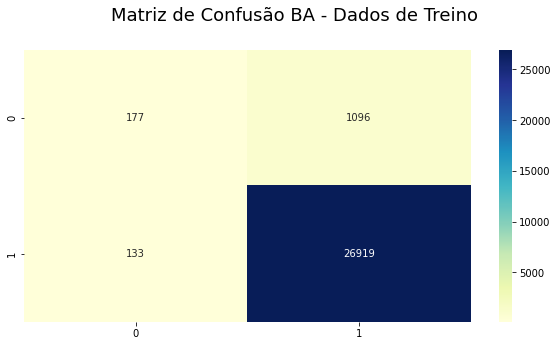



Reporte dos Dados de Teste - BA
              precision    recall  f1-score   support

           0       0.61      0.15      0.24       572
           1       0.96      1.00      0.98     11756

    accuracy                           0.96     12328
   macro avg       0.79      0.57      0.61     12328
weighted avg       0.94      0.96      0.94     12328





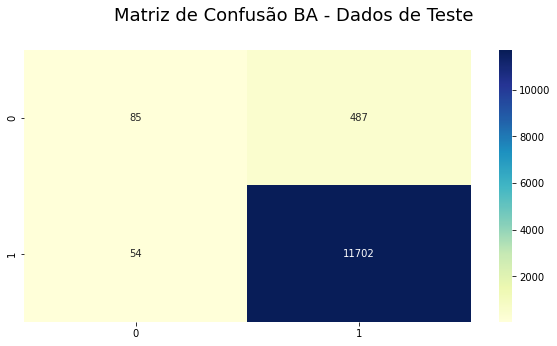

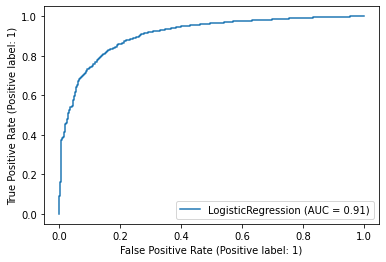

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model.score(xteste,yteste))
  print('\033[1m'+'Intercept:'+'\033[0m',model.intercept_,'\033[1m')
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - BA'+'\033[0m')
  print(classification_report(ytreino, model.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - BA'+'\033[0m')
  print(classification_report(yteste, model.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model.coef_).T
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
182,1.76e-02,v248
148,1.05e-02,v201
147,8.10e-03,v200
119,6.87e-03,v170
43,6.87e-03,v61
...,...,...
184,-4.26e-03,v250
176,-4.47e-03,v242
181,-1.90e-02,v247
35,-4.14e-02,v51


In [ ]:
n=gc.collect()

##Modelo 1: Árvore de Decisão.

In [ ]:
model1 = DecisionTreeClassifier(max_depth=2, random_state=18)

In [ ]:
with parallel_backend('dask'):
  model1.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9597881729920564 R² de teste: 0.9597663854639844
RMSE de Treino: 0.04021182700794351 RMSE de Teste: 0.04023361453601557


Reporte dos Dados de Treino - BA
              precision    recall  f1-score   support

           0       0.74      0.16      0.27      1273
           1       0.96      1.00      0.98     27052

    accuracy                           0.96     28325
   macro avg       0.85      0.58      0.62     28325
weighted avg       0.95      0.96      0.95     28325





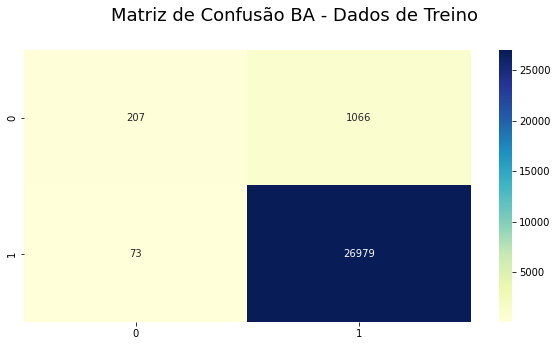



Reporte dos Dados de Teste - BA
              precision    recall  f1-score   support

           0       0.81      0.17      0.29       572
           1       0.96      1.00      0.98     11756

    accuracy                           0.96     12328
   macro avg       0.88      0.59      0.63     12328
weighted avg       0.95      0.96      0.95     12328





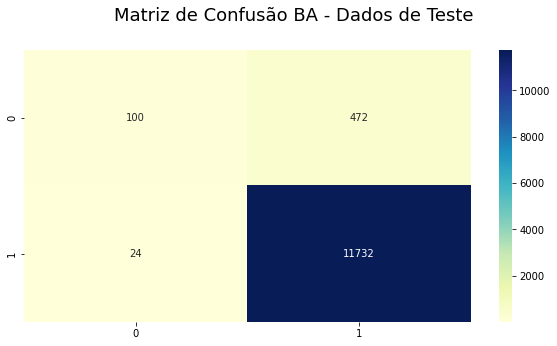

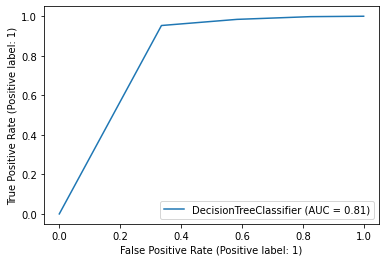

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model1.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model1.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model1.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model1.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - BA'+'\033[0m')
  print(classification_report(ytreino, model1.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model1.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - BA'+'\033[0m')
  print(classification_report(yteste, model1.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model1.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model1,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model1.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
51,0.70,v69
7,0.24,v7
34,0.06,v50
132,0.00,v183
123,0.00,v174
...,...,...
67,0.00,v92
68,0.00,v93
69,0.00,v94
70,0.00,v96


In [ ]:
n=gc.collect()

##Modelo 2: Ada Boost.

In [ ]:
model2 = AdaBoostClassifier(n_estimators=50)

In [ ]:
with parallel_backend('dask'):
  model2.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9671668137687555 R² de teste: 0.9680402336145361
RMSE de Treino: 0.03283318623124448 RMSE de Teste: 0.03195976638546399


Reporte dos Dados de Treino - BA
              precision    recall  f1-score   support

           0       0.70      0.47      0.56      1273
           1       0.98      0.99      0.98     27052

    accuracy                           0.97     28325
   macro avg       0.84      0.73      0.77     28325
weighted avg       0.96      0.97      0.96     28325





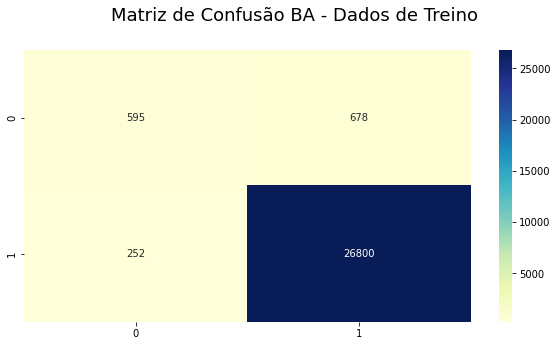



Reporte dos Dados de Teste - BA
              precision    recall  f1-score   support

           0       0.72      0.51      0.59       572
           1       0.98      0.99      0.98     11756

    accuracy                           0.97     12328
   macro avg       0.85      0.75      0.79     12328
weighted avg       0.96      0.97      0.97     12328





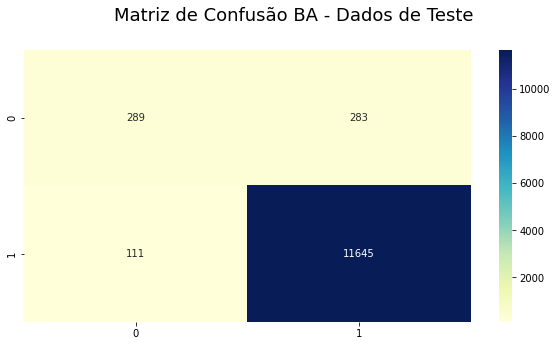

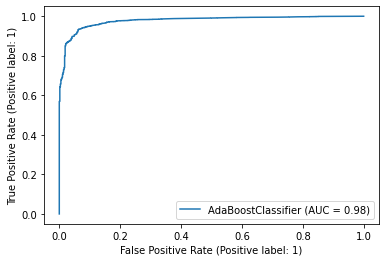

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model2.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model2.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model2.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model2.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - BA'+'\033[0m')
  print(classification_report(ytreino, model2.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model2.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - BA'+'\033[0m')
  print(classification_report(yteste, model2.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model2.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model2,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model2.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
33,0.10,v48
4,0.08,v4
165,0.06,v220
84,0.06,v117
73,0.06,v100
...,...,...
76,0.00,v107
77,0.00,v108
78,0.00,v109
79,0.00,v112


In [ ]:
n=gc.collect()

##Modelo 3: Gradient Boosting.

In [ ]:
model3 = GradientBoostingClassifier(n_estimators=300)

In [ ]:
with parallel_backend('dask'):
  model3.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9884554280670785 R² de teste: 0.9808565866320571
RMSE de Treino: 0.011544571932921447 RMSE de Teste: 0.019143413367942893


Reporte dos Dados de Treino - BA
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      1273
           1       0.99      1.00      0.99     27052

    accuracy                           0.99     28325
   macro avg       0.94      0.92      0.93     28325
weighted avg       0.99      0.99      0.99     28325





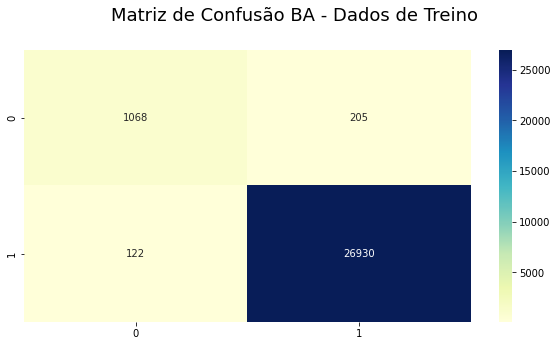



Reporte dos Dados de Teste - BA
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       572
           1       0.99      0.99      0.99     11756

    accuracy                           0.98     12328
   macro avg       0.91      0.87      0.89     12328
weighted avg       0.98      0.98      0.98     12328





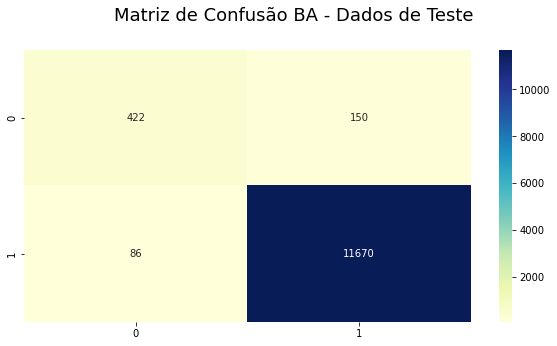

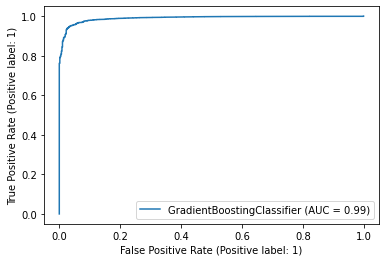

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model3.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model3.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model3.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model3.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - BA'+'\033[0m')
  print(classification_report(ytreino, model3.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model3.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - BA'+'\033[0m')
  print(classification_report(yteste, model3.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model3.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model3,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model3.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
51,0.10,v69
35,0.09,v51
33,0.08,v48
5,0.07,v5
73,0.06,v100
...,...,...
110,0.00,v161
83,0.00,v116
76,0.00,v107
75,0.00,v106


In [ ]:
n=gc.collect()

##Modelo 4: Bagging.

In [ ]:
model4 = BaggingClassifier(n_estimators=1)

In [ ]:
with parallel_backend('dask'):
  model4.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9894086496028244 R² de teste: 0.9717715768981181
RMSE de Treino: 0.01059135039717564 RMSE de Teste: 0.028228423101881894


Reporte dos Dados de Treino - BA
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1273
           1       0.99      0.99      0.99     27052

    accuracy                           0.99     28325
   macro avg       0.94      0.94      0.94     28325
weighted avg       0.99      0.99      0.99     28325





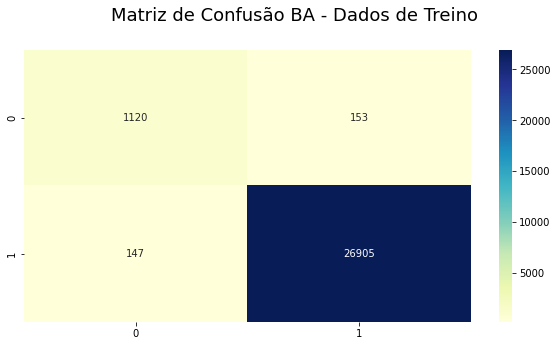



Reporte dos Dados de Teste - BA
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       572
           1       0.98      0.99      0.99     11756

    accuracy                           0.97     12328
   macro avg       0.84      0.83      0.84     12328
weighted avg       0.97      0.97      0.97     12328





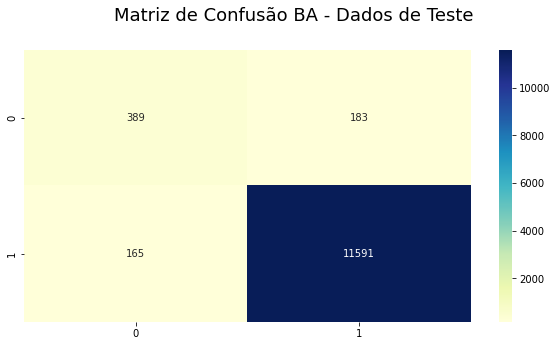

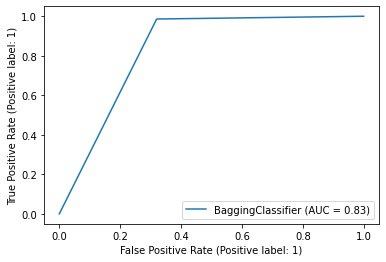

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model4.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model4.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model4.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model4.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - BA'+'\033[0m')
  print(classification_report(ytreino, model4.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model4.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - BA'+'\033[0m')
  print(classification_report(yteste, model4.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model4.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model4,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
n=gc.collect()

##Modelo 5: Random Forrest.

In [ ]:
model5 = RandomForestClassifier(n_estimators=2)

In [ ]:
with parallel_backend('dask'):
  model5.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9863724624889674 R² de teste: 0.959604153147307
RMSE de Treino: 0.013627537511032657 RMSE de Teste: 0.040395846852693054


Reporte dos Dados de Treino - BA
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1273
           1       1.00      0.99      0.99     27052

    accuracy                           0.99     28325
   macro avg       0.89      0.98      0.93     28325
weighted avg       0.99      0.99      0.99     28325





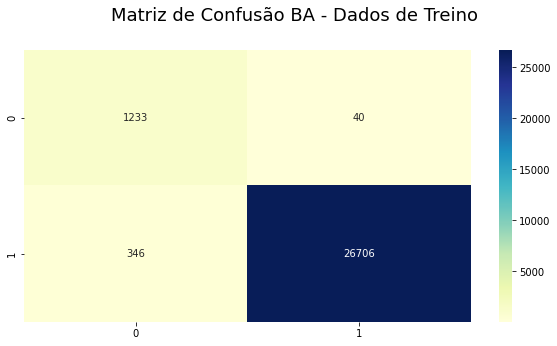



Reporte dos Dados de Teste - BA
              precision    recall  f1-score   support

           0       0.55      0.77      0.64       572
           1       0.99      0.97      0.98     11756

    accuracy                           0.96     12328
   macro avg       0.77      0.87      0.81     12328
weighted avg       0.97      0.96      0.96     12328





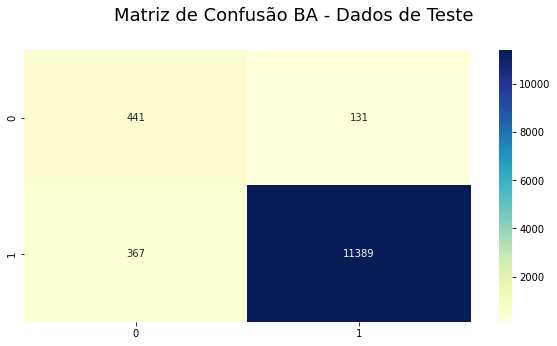

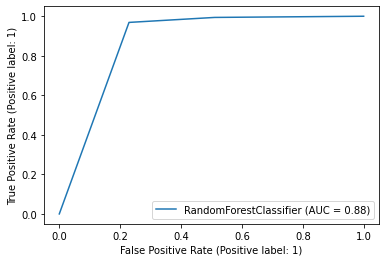

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model5.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model5.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model5.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model5.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - BA'+'\033[0m')
  print(classification_report(ytreino, model5.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model5.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - BA'+'\033[0m')
  print(classification_report(yteste, model5.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model5.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model5,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model5.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [ ]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
34,0.06,v50
51,0.04,v69
58,0.03,v79
50,0.03,v68
32,0.03,v47
...,...,...
68,0.00,v93
69,0.00,v94
126,0.00,v177
125,0.00,v176


In [ ]:
n=gc.collect()

##Modelo 6: Suport Vector Machine (kernel rbf).

In [ ]:
model6 = SVC(C=30000)

In [ ]:
with parallel_backend('dask'):
  model6.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9593292144748455 R² de teste: 0.9573329007138222
RMSE de Treino: 0.040670785525154456 RMSE de Teste: 0.042667099286177804


Reporte dos Dados de Treino - BA
              precision    recall  f1-score   support

           0       0.85      0.11      0.20      1273
           1       0.96      1.00      0.98     27052

    accuracy                           0.96     28325
   macro avg       0.91      0.56      0.59     28325
weighted avg       0.96      0.96      0.94     28325





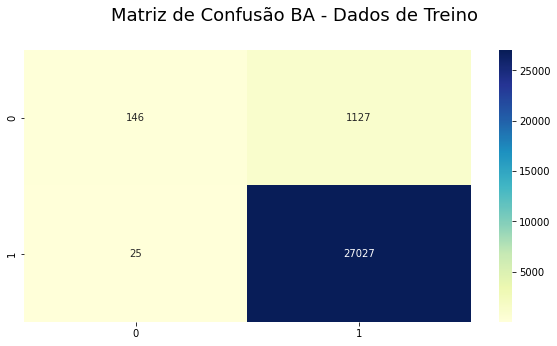



Reporte dos Dados de Teste - BA
              precision    recall  f1-score   support

           0       0.86      0.10      0.17       572
           1       0.96      1.00      0.98     11756

    accuracy                           0.96     12328
   macro avg       0.91      0.55      0.58     12328
weighted avg       0.95      0.96      0.94     12328





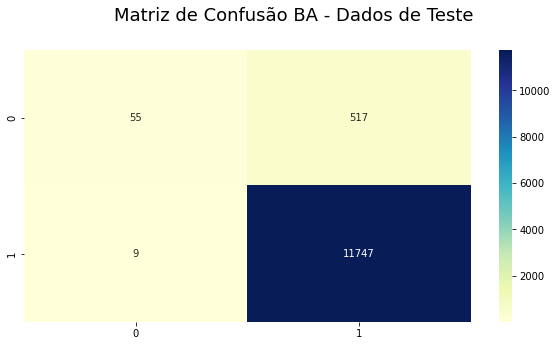

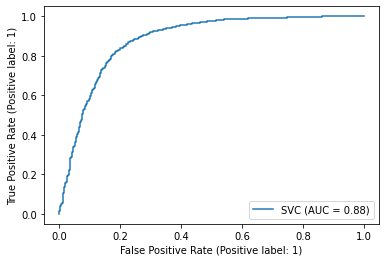

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model6.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model6.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model6.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model6.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - BA'+'\033[0m')
  print(classification_report(ytreino, model6.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model6.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - BA'+'\033[0m')
  print(classification_report(yteste, model6.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model6.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model6,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
n=gc.collect()

##Modelo 7: KNN.

In [ ]:
model7 = KNeighborsClassifier(n_neighbors=3)

In [ ]:
with parallel_backend('dask'):
  model7.fit(xtreino,ytreino)

In [ ]:
n=gc.collect()

R² de treino: 0.9744042365401588 R² de teste: 0.9616320571057755
RMSE de Treino: 0.02559576345984113 RMSE de Teste: 0.03836794289422453


Reporte dos Dados de Treino - BA
              precision    recall  f1-score   support

           0       0.83      0.54      0.65      1273
           1       0.98      0.99      0.99     27052

    accuracy                           0.97     28325
   macro avg       0.91      0.77      0.82     28325
weighted avg       0.97      0.97      0.97     28325





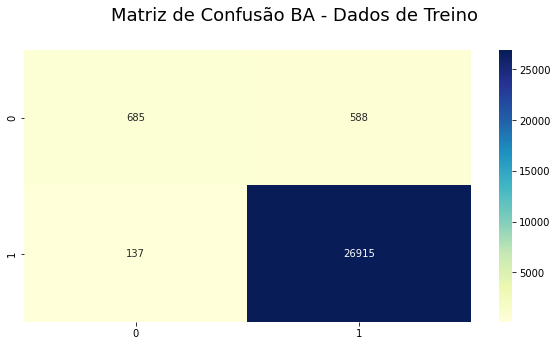



Reporte dos Dados de Teste - BA
              precision    recall  f1-score   support

           0       0.64      0.39      0.48       572
           1       0.97      0.99      0.98     11756

    accuracy                           0.96     12328
   macro avg       0.81      0.69      0.73     12328
weighted avg       0.96      0.96      0.96     12328





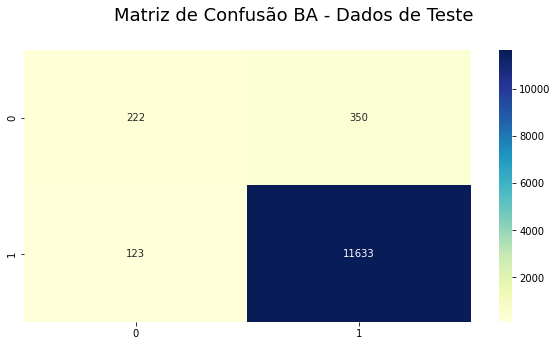

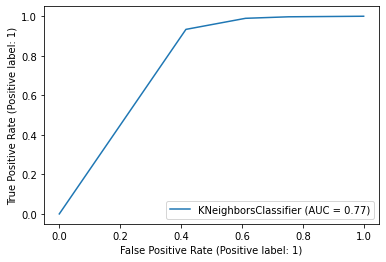

In [ ]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model7.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model7.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model7.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model7.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - BA'+'\033[0m')
  print(classification_report(ytreino, model7.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model7.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - BA'+'\033[0m')
  print(classification_report(yteste, model7.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model7.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão BA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model7,xteste,yteste)
  plt.show()
  print('\n')

In [ ]:
n=gc.collect()

##Consolidação das Curvas ROC

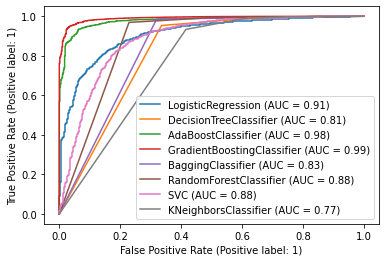

In [ ]:
with parallel_backend('dask'):
  classifiers = [model,model1, model2, model3, model4, model5, model6, model7]
  ax = plt.gca()
  for i in classifiers:
      metrics.plot_roc_curve(i, xteste, yteste, ax=ax)